In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import datetime

import keras
from keras import backend as K
from keras import optimizers
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D,Conv2D,Input
from keras.layers.core import Activation, Dense, Flatten,Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
keras.backend.clear_session()
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os
import os.path
import shutil 
from google.colab import drive
from keras.models import load_model
%load_ext tensorboard
drive.mount('/content/gdrive',force_remount=True)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Mounted at /content/gdrive


In [9]:
my_string='abddty'
list1=[]
k=[list1.append(i) for i in my_string if i not in "aeiou"]
print(k)

[None, None, None, None, None]


4

In [0]:
train_dir ='/content/gdrive/My Drive/MScthesis/train/'
validation_dir = '/content/gdrive/My Drive/MScthesis/validation/'

# Directory with our training residential pictures
train_residential_dir = os.path.join(train_dir, 'residential')
print ('Total training residential images:', len(os.listdir(train_residential_dir)))

# Directory with our training non-residential pictures
train_nonresidential_dir = os.path.join(train_dir, 'nonresidential')
print ('Total training non-residential images:', len(os.listdir(train_nonresidential_dir)))

# Directory with our validation residential pictures
validation_residential_dir = os.path.join(validation_dir, 'residential')
print ('Total validation residential images:', len(os.listdir(validation_residential_dir)))

# Directory with our validation non-residential pictures
validation_nonresidential_dir = os.path.join(validation_dir, 'nonresidential')
print ('Total validation non-residential images:', len(os.listdir(validation_nonresidential_dir)))

Total training residential images: 7357
Total training non-residential images: 3803
Total validation residential images: 681
Total validation non-residential images: 551


In [0]:
batch_size = 64
image_size = 160
# Rescale all images by 1./255 and apply image augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
#                                     rotation_range=3,
#                                     shear_range=0.2,
#                                     zoom_range=0.2,
#                                     fill_mode='nearest',
#                                     width_shift_range=0.1,
#                                     horizontal_flip=True,
#                                     height_shift_range=0.1,
                                  )

validation_datagen = ImageDataGenerator(rescale=1./255,
#                                         rotation_range=3,
#                                         shear_range=0.2,
#                                         zoom_range=0.2,
#                                         fill_mode='nearest',
#                                         width_shift_range=0.1,
#                                         horizontal_flip=True,
#                                         height_shift_range=0.1,
                                       )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,  # Source directory for the training images
                                                    target_size=(image_size, image_size),
                                                    batch_size=batch_size,
                                                    class_mode='binary')  # Since we use binary_crossentropy loss, we need binary labels

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(validation_dir, # Source directory for the validation images
                                                              target_size=(image_size, image_size),
                                                              batch_size=batch_size,
                                                              shuffle=False,
                                                              class_mode='binary')

Found 11160 images belonging to 2 classes.
Found 1232 images belonging to 2 classes.


In [0]:
IMG_SHAPE = (image_size, image_size, 3)
# Create the base model from the pre-trained model MobileNet V2
base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                      include_top=False,
                      weights='imagenet')

In [0]:
base_model.trainable = False
# base_model.summary()

In [0]:
import tensorflow as tf
#recall
# def recall_m(y_true, y_pred):
#         true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#         possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#         recall = true_positives / (possible_positives + K.epsilon())
#         return recall

# #precision
# def precision_m(y_true, y_pred):
#         true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#         predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#         precision = true_positives / (predicted_positives + K.epsilon())
#         return precision

# #f1_score
# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

#focal loss
def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed


In [0]:
dropout_rate = 0.5
model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(256,activation='relu',name='fc1'),
  Dropout(rate = dropout_rate, name="dropout_out"),
  Dense(1, activation='sigmoid',name='predictions')
])

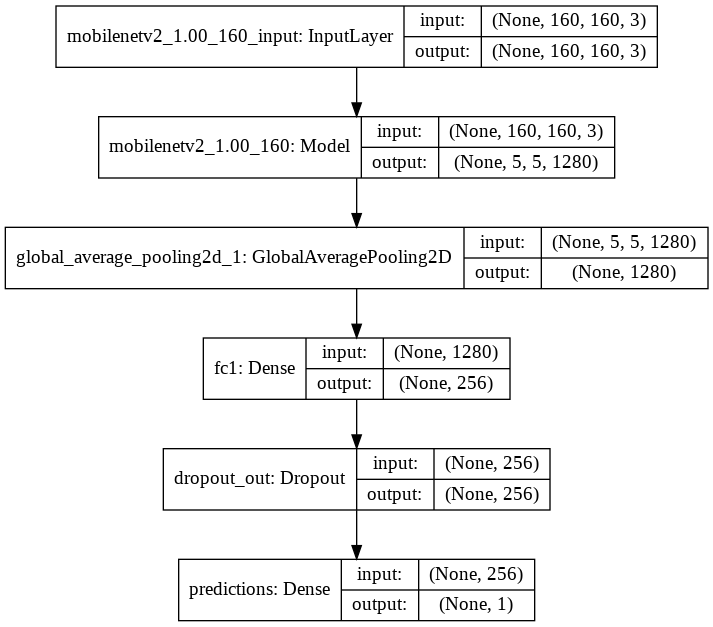

In [0]:
from keras.utils import plot_model
plot_model(model, show_shapes=True,to_file='/content/models.png')

In [0]:
model.compile(optimizer=optimizers.adam(lr=1e-4),
            loss='binary_crossentropy',
            metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 256)               327936    
_________________________________________________________________
dropout_out (Dropout)        (None, 256)               0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 257       
Total params: 2,586,177
Trainable params: 328,193
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
EARLY_STOP_PATIENCE = 5
# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
# STEPS_PER_EPOCH_TRAINING = 10
# STEPS_PER_EPOCH_VALIDATION = 10
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
# from keras import callbacks as cbs
import tensorboardcolab as tbc
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE,restore_best_weights=True)

In [0]:
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size
history = model.fit_generator(train_generator,
                steps_per_epoch = steps_per_epoch,
                epochs=epochs,
                workers=4,
                validation_data=validation_generator,
                validation_steps=validation_steps,
                callbacks=[cb_early_stopper])

Epoch 1/10
174/174 [==============================] - 86s 493ms/step - loss: 0.5239 - acc: 0.7459 - val_loss: 0.7724 - val_acc: 0.6324
Epoch 2/10
174/174 [==============================] - 83s 474ms/step - loss: 0.4256 - acc: 0.8108 - val_loss: 0.8323 - val_acc: 0.6250
Epoch 3/10
174/174 [==============================] - 82s 468ms/step - loss: 0.3980 - acc: 0.8269 - val_loss: 0.7549 - val_acc: 0.6610
Epoch 4/10
174/174 [==============================] - 80s 461ms/step - loss: 0.3784 - acc: 0.8357 - val_loss: 0.7241 - val_acc: 0.6661
Epoch 5/10
174/174 [==============================] - 82s 470ms/step - loss: 0.3492 - acc: 0.8520 - val_loss: 0.6856 - val_acc: 0.6729
Epoch 6/10
174/174 [==============================] - 84s 481ms/step - loss: 0.3455 - acc: 0.8499 - val_loss: 0.7225 - val_acc: 0.6755
Epoch 7/10
174/174 [==============================] - 83s 474ms/step - loss: 0.3285 - acc: 0.8636 - val_loss: 0.7570 - val_acc: 0.6721
Epoch 8/10
174/174 [==============================] - 8

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

Fine-tuning

In [0]:
base_model.trainable = True

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 80

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [0]:
!mkdir models

In [0]:
EARLY_STOP_PATIENCE = 5
# from keras import callbacks as cbs
import tensorboardcolab as tbc
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
cb_early_stopper = EarlyStopping(monitor = 'val_acc', patience = EARLY_STOP_PATIENCE, restore_best_weights=True)
cb_checkpointer  = ModelCheckpoint(filepath = '/content/models/MobileNetV2-{val_loss:.4f}-{val_acc:.4f}.h5', monitor = 'val_acc', save_best_only = True, mode = 'auto')

In [0]:
model.compile(optimizer=optimizers.SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True),
#               loss=[focal_loss(alpha=.25, gamma=2)],
              loss='binary_crossentropy',
              metrics=['acc'])
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard= TensorBoard(logdir, histogram_freq=1)
model.summary()

W0831 19:21:18.742124 140049405835136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0831 19:21:18.756259 140049405835136 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 256)               327936    
_________________________________________________________________
dropout_out (Dropout)        (None, 256)               0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 257       
Total params: 2,586,177
Trainable params: 2,367,105
Non-trainable params: 219,072
_________________________________________________________________


In [0]:
len(model.trainable_weights)

91

In [0]:
tbc.TensorBoardColab(graph_path=logdir);

Wait for 8 seconds...
TensorBoard link:
http://ad3b6485.ngrok.io


In [0]:
# %tensorboard --logdir logs

0.83

In [0]:
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size
history_fine = model.fit_generator(train_generator,
                  steps_per_epoch = steps_per_epoch,
                  epochs=20,
                  workers=4,
                  validation_data=validation_generator,
                  validation_steps=validation_steps,
                  callbacks=[cb_checkpointer,cb_early_stopper])


Epoch 1/20
174/174 [==============================] - 883s 5s/step - loss: 0.6692 - acc: 0.6363 - val_loss: 0.5841 - val_acc: 0.7081
Epoch 2/20
174/174 [==============================] - 90s 516ms/step - loss: 0.5211 - acc: 0.7401 - val_loss: 0.5204 - val_acc: 0.7568
Epoch 3/20
174/174 [==============================] - 88s 509ms/step - loss: 0.4624 - acc: 0.7894 - val_loss: 0.4667 - val_acc: 0.7920
Epoch 4/20
174/174 [==============================] - 88s 507ms/step - loss: 0.4061 - acc: 0.8242 - val_loss: 0.4796 - val_acc: 0.7911
Epoch 5/20
174/174 [==============================] - 88s 504ms/step - loss: 0.3817 - acc: 0.8355 - val_loss: 0.4678 - val_acc: 0.7962
Epoch 6/20
174/174 [==============================] - 87s 500ms/step - loss: 0.3586 - acc: 0.8477 - val_loss: 0.4619 - val_acc: 0.8005
Epoch 7/20
174/174 [==============================] - 88s 506ms/step - loss: 0.3406 - acc: 0.8541 - val_loss: 0.4634 - val_acc: 0.7997
Epoch 8/20
174/174 [==============================] - 86s

In [0]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [0]:
acc = history_fine.history['acc']
val_acc = history_fine.history['val_acc']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

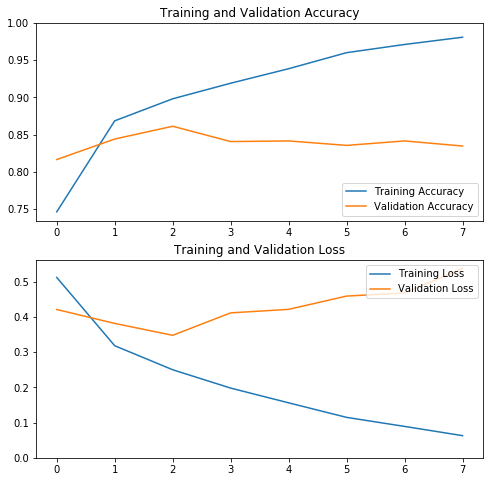

In [0]:
epochs=20
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
# plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0,max(plt.ylim())])
# plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Plot confusion matrix

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
from numpy import *
random.seed(5)
import seaborn as sns
#Confution Matrix and Classification Report
threshold = 0.50
batch_size= 16
Y_pred = model.predict_generator(test_gen, test_gen.n // batch_size+1,workers = 4,verbose=1)
y_pred = np.where(Y_pred > threshold, 1,0)
print('Classification Report')
target_names = ['nonresidential','residential']
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

40/40 [==============================] - 4s 104ms/step
Classification Report
                precision    recall  f1-score   support

nonresidential       0.72      0.40      0.52       156
   residential       0.83      0.95      0.88       471

      accuracy                           0.81       627
     macro avg       0.78      0.68      0.70       627
  weighted avg       0.80      0.81      0.79       627



In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
#Confution Matrix and Classification Report
# threshold = 0.60
Y_pred = model.predict_generator(test_gen, test_gen.n // batch_size+1,workers=4,verbose=1).ravel()
# y_pred = np.where(Y_pred > threshold, 1,0)
target_names = ['nonresidential','residential']
# print(classification_report(validation_generator.classes, Y_pred, target_names=target_names))

40/40 [==============================] - 85s 2s/step


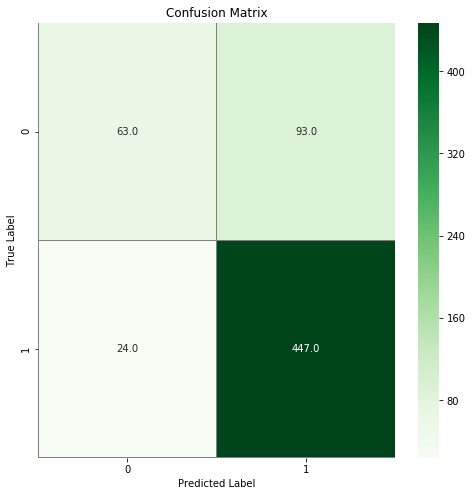

In [0]:
confusion_mtx = confusion_matrix(test_gen.classes, y_pred) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

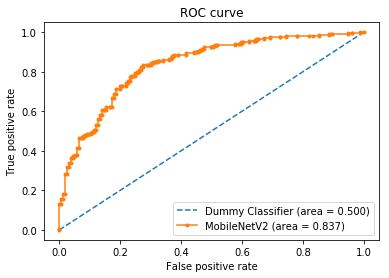

In [0]:
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.metrics import precision_recall_curve,f1_score,average_precision_score
from matplotlib import pyplot as plt
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_gen.classes, Y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], linestyle='--',label='Dummy Classifier (area = 0.500)')
plt.plot(fpr_keras, tpr_keras, label='MobileNetV2 (area = {:.3f})'.format(auc_keras),marker='.')
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_gen.classes, y_pred)
# calculate F1 score
f1 = f1_score(test_gen.classes, y_pred)
# calculate precision-recall AUC
rp_auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_gen.classes, y_pred)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, rp_auc, ap))


f1=0.884 auc=0.908 ap=0.824


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.93')

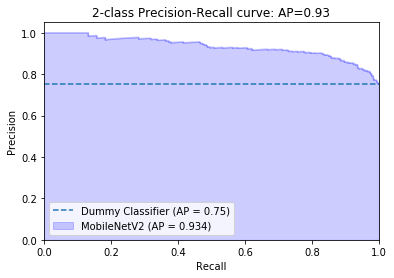

In [0]:
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.metrics import precision_recall_curve,f1_score,average_precision_score
precision, recall, _ = precision_recall_curve(test_gen.classes, Y_pred)
average_precision = average_precision_score(test_gen.classes, Y_pred)
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b',label='MobileNetV2 (AP = {:.3f})'.format(average_precision))
plt.plot([0, 1], [0.75,0.75], linestyle='--',label='Dummy Classifier (AP = 0.75)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc='best')
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

# Save the model

In [0]:
!cp -r /content/models gdrive/My\ Drive/MScthesis

# Load the model

In [0]:
from keras.models import load_model
model=load_model('/content/gdrive/My Drive/MScthesis/models/MobileNetV2-0.3480-0.8613.h5')

W0906 15:07:17.538095 140655875843968 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0906 15:07:17.548134 140655875843968 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
test_dir='/content/gdrive/My Drive/MScthesis/test/'
# Directory with our test non-residential pictures
test_nonresidential_dir = os.path.join(test_dir, 'nonresidential')
print ('Total test non-residential images:', len(os.listdir(test_nonresidential_dir)))

# Directory with our test residential pictures
test_residential_dir = os.path.join(test_dir, 'residential')
print ('Total test residential images:', len(os.listdir(test_residential_dir)))

Total test non-residential images: 156
Total test residential images: 471


In [0]:
image_size = 160
batch_size=16
test_idg = ImageDataGenerator(rescale=1./255)
test_gen = test_idg.flow_from_directory(
    '/content/gdrive/My Drive/MScthesis/test/',
    target_size=(image_size, image_size),
    batch_size = 16,
    shuffle = False,
    class_mode='binary',
    seed=1
)
len(test_gen.filenames)

Found 627 images belonging to 2 classes.


627

In [0]:
test_steps = test_gen.n // batch_size
loss, acc = model.evaluate_generator(test_gen, steps = test_steps, workers = 4, verbose=1)

39/39 [==============================] - 58s 1s/step


In [0]:
print(acc,loss)

0.8141025641025641 0.5327646258072212


In [0]:
# history_fine = model.fit_generator(train_generator,
#                                    steps_per_epoch = steps_per_epoch,
#                                    epochs=1,
#                                    workers=4,
#                                    validation_data=validation_generator,
#                                    validation_steps=validation_steps,
#                                   callbacks=[cb_checkpointer,cb_early_stopper])

# Save and load model

In [0]:
model.save('models/keras/model.h5')

Make predictions on sample test images

In [0]:
validation_img_paths = ["validation/alien/11.jpg",
                        "validation/alien/22.jpg",
                        "validation/predator/33.jpg"]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]

In [0]:
validation_batch = np.stack([preprocess_input(np.array(img.resize((224,224))))
                             for img in img_list])

In [0]:
pred_probs = model.predict(validation_batch)
pred_probs

In [0]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)